# Simulating Experimental Data from Observational Data

This chapter deals with interventions which the book defines as *something an agent does to cause other things to happen; generally interventions change the DGP*


In many cases, deploying ml models will impact the DGP (i.e. future data) through the *predictions/decisions* they make. The book gives two examples from two different domains and the future impact of the DGP.


The first domain deals with meteorology in which the ml model is trained to predict whether to bring an umbrella based on sensor data. After being trained, the model is deployed into the wild and retrained with additional data. In this domain the ml model's prediction/decision has *no effect on the DGP process* since deciding whether to bring an umbrella has no effect on predicting future weather patterns.


The second domain deals with a business example in which the ml model is trained to predict whether to spend money on advertising based on past data of the business’ profitability. After the model is trained, the model is deployed into the wild and *retrained with additional data*. However, unlike in the first domain, in this domain the prediction/decision of the ml model will affect the DGP, since the ml model's prediction/decision of spending money on advertising will affect the business’ future profitability.


As the book states:


>  [I]n many, if not most, domains where we want to use machine learning, *those model-driven decisions are interventions—actions that change the DGP*. That can lead to a mismatch between the model’s training and deployment conditions, leading to problems in the model’s reliability.


Generally companies rely on randomized experiments to make intervention decisions. For example designing a game to have more side quests so that users make more in-game purchases. While this is the correct method there is a cost to running randomized experiments on unsuspecting users of a video game.


It would be nice to use the observational data of users just playing the game to make the *correct intervention decision*; enter causal modeling. This example constructs a causal model to simulate the results of conducting a randomized experiment without actually conducting a randomized experiment. This is done using [pyro](https://pyro.ai/) and its *do* function.


In [ ]:
!pip install pyro-ppl
!pip install pgmpy

In [ ]:
import pandas as pd

In [ ]:
url = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/sidequests_and_purchases_full_obs.csv"

In [ ]:
df=pd.read_csv(url)

In [ ]:
# p(guild_membership)
member_counts = df['Guild Membership'].value_counts()
dist_guild_membership = member_counts/sum(member_counts)
dist_guild_membership

,count
Guild Membership,
nonmember,0.515
member,0.485


In [ ]:
# p(side_quest_engage | guild_membership)
member_subset = df[(df['Guild Membership'] == 'member')]
member_engagement_counts = (
    member_subset['Side-quest Engagement'].value_counts()
)
dist_engagement_member = (
    member_engagement_counts / sum(member_engagement_counts)
)
dist_engagement_member

,count
Side-quest Engagement,
high,0.797938
low,0.202062


In [ ]:
# p(in_game_purchase | side_quest_engage, guild_membership)
purchase_dist_nonmember_low_engagement = df[
    (df['Guild Membership'] == 'nonmember') &
    (df['Side-quest Engagement'] == 'low')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1
).agg(['mean', 'std'])
print(round(purchase_dist_nonmember_low_engagement, 2))

purchase_dist_nonmember_high_engagement = df[
    (df['Guild Membership'] == 'nonmember') &
    (df['Side-quest Engagement'] == 'high')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1
).agg(['mean', 'std'])
print(round(purchase_dist_nonmember_high_engagement, 2))

purchase_dist_member_low_engagement = df[
    (df['Guild Membership'] == 'member') &
    (df['Side-quest Engagement'] == 'low')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1
).agg(['mean', 'std'])
print(round(purchase_dist_member_low_engagement, 2))

purchase_dist_member_high_engagement = df[
    (df['Guild Membership'] == 'member') &
    (df['Side-quest Engagement'] == 'high')
].drop(
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1
).agg(['mean', 'std'])
print(round(purchase_dist_member_high_engagement, 2))

      In-game Purchases
mean              37.95
std               23.80
      In-game Purchases
mean              54.92
std                4.92
      In-game Purchases
mean             223.71
std                5.30
      In-game Purchases
mean             125.53
std               53.44


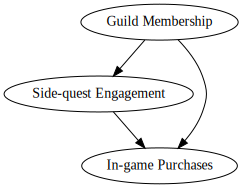

In [ ]:
# Building causal model of In-Game Purchases
import pyro
from torch import tensor
from pyro.distributions import Bernoulli, Normal

def model():
    p_member = tensor(0.5)
    is_guild_member = pyro.sample(
        "Guild Membership",
        Bernoulli(p_member)
    )
    p_engaged = (tensor(0.8)*is_guild_member +
                 tensor(.2)*(1-is_guild_member))
    is_highly_engaged = pyro.sample(
        "Side-quest Engagement",
        Bernoulli(p_engaged)
    )
    get_purchase_param = lambda param1, param2, param3, param4: (
        param1 * (1-is_guild_member) * (1-is_highly_engaged) +
        param2 * (1-is_guild_member) * (is_highly_engaged) +
        param3 * (is_guild_member)   * (1-is_highly_engaged) +
        param4 * (is_guild_member)   * (is_highly_engaged)
    )
    μ = get_purchase_param(37.95, 54.92, 223.71, 125.50)
    σ = get_purchase_param(23.80, 4.92, 5.30, 53.49)
    in_game_purchases = pyro.sample(
        "In-game Purchases",
        Normal(μ, σ)
    )
    guild_membership = "member" if is_guild_member else "nonmember"     #5
    engagement = "high" if is_highly_engaged else "low"
    in_game_purchases = float(in_game_purchases)
    return guild_membership, engagement, in_game_purchases
pyro.render_model(model)

In [ ]:
# intervention models
int_engaged_model = pyro.do(model, data={"Side-quest Engagement": tensor(1)})
int_unengaged_model = pyro.do(model, data={"Side-quest Engagement": tensor(0)})

In [ ]:
# simulate experiment with intervention models
pyro.util.set_rng_seed(123)
simulated_experimental_data = [
    int_engaged_model() for _ in range(500)
] + [
    int_unengaged_model() for _ in range(500)
]
simulated_experimental_data = pd.DataFrame(
    simulated_experimental_data,
    columns=[
        "Guild Membership",
        "Side-quest Engagement",
        "In-Game Purchases"
    ]
)
sim_exp_df = simulated_experimental_data.drop(
    "Guild Membership", axis=1)
summary = sim_exp_df.groupby(
        ["Side-quest Engagement"]
    ).agg(
        ['count', 'mean', 'std']
    )
print(summary)

                      In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                500   89.897309  52.696709
low                                 500  130.674021  93.921543
